<i><b>Public-AI</b></i>

# Class Activation Map이란


### _Objective_

* 모델이 클래스를 분류할 때, 이미지의 어느 부분을 중심으로 파악했는지를 알 수 있는 Class Activation Map에 대해 배워보도록 하겠습니다.


In [4]:
%matplotlib inline
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf

from zipfile import ZipFile

import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

## Dataset) Cat VS Dog Dataset

개와 고양이를 분류하기 위해, 아래와 같이 데이터셋을 준비하였습니다.<Br> 

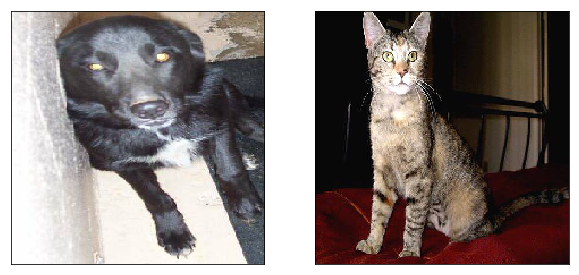

In [5]:
data_dir = "cat-vs-dog"
fpath = get_file("cat-vs-dog.zip", 
                 "https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cat-vs-dog.zip")

if not os.path.exists(data_dir):
    with ZipFile(fpath,'r') as f:
        f.extractall(data_dir)
        
# 이미지 시각화하기 
dog_path = os.path.join(data_dir,'train','dog','dog.10000.jpg')
dog_image = Image.open(dog_path)
dog_image = np.array(dog_image.resize((224,224)))

cat_path = os.path.join(data_dir,'train','cat','cat.10000.jpg')
cat_image = Image.open(cat_path)
cat_image = np.array(cat_image.resize((224,224)))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(dog_image)
ax = fig.add_subplot(1,2,2)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(cat_image)
plt.show()        

<br><br>

# \[ Class Activation Map 이란? \]
---

* 클래스 활성화 맵(Class Activation Map) 시각화란, 특정 출력 클래스에 대해 입력 이미지의 위치 별 점수를 계산한 2D 그리드입니다.
* 클래스 활성화 맵은 클래스에 대해 각 위치가 얼마나 중요한지 알려 줍니다.

![Imgur](https://i.imgur.com/yRyOzrd.png)

Reference : [Learning Deep Features For Discriminative Localization](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)

<br>

# 1. Class Activation Map을 계산하는 방법

* Class Activation Map을 구성하는 방법은 여러가지가 있지만, 가장 처음으로 만들어진 방식은Global Average Pooling 방식을 이용해서 구현한 것입니다. <br>

### (1) Global Average Pooling의 의미

Global Average Pooling의 진정한 의미는 각 필터 별로, 정보를 요약하는 데에 있습니다.<br> 
각 필터층은 각기 다른 특성들을 파악하는데, Global Average Pooling을 거치면, 위치에 무관하게 <br> 특성 정보를 요약할 수 있습니다.

![Imgur](https://i.imgur.com/UWOYkns.png)

### (2) Class Activation Map을 구하는 방법

![Imgur](https://i.imgur.com/ar3dZLp.png)

*Learning Deep Features for Discriminative Localization* 논문은 매우 간단한 아이디어입니다.<br>
마지막 Classifier에서 학습한 Weight은 해당 클래스가 어떤 Filter을 중심으로 파악하고 있는지를 배웁니다.<br> 
그러면 각 Filter의 Feature Map에 Weight을 곱해준 것들을 더해주면, 실제로 Filter가 강하게 존재했던 곳들 위주로 큰 값이 가지게 될 것이고, 중요하지 않았던 부분들은 그 값이 줄어들게 될 것입니다.

![Imgur](https://i.imgur.com/PVItO99.png)


### (3) Class Activation Map을 적용하는 방법

이전에 배웠던 Transfer Learning 방식처럼, 우선 모델의 CNN 부분을 떼어다가 <bR>
그 위에 Global Average Pooling과 Fully Connected Layer을 하나 붙이는 방식으로 구현할 수 있습니다.<br>
    
![Imgur](https://i.imgur.com/bggn8oQ.png)

<br>

## 2. VGG Network 구성하기


* 기학습된 VGG Network 가져와, 개와 고양이를 분류하는 모델을 구성해보도록 하겠습니다.

### (1) VGG 모델 가져오기

In [6]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', 
              include_top=False)

### (2) GAP(Global Average Pooling)과 Classifier 붙이기

마지막 Feature Map의 좀더 정확한 출력을 위해 Fine-Tune을 시도해 보도록 하겠습니다.<br>

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [8]:
for layer in vgg16.layers[:-2]:
    # 마지막 Convolution Layer을 제외하고 
    # 모두 Freezing하기
    layer.trainable = False

output = vgg16.output
gap = GlobalAveragePooling2D()(output)
pred = Dense(1, activation='sigmoid')(gap)

model = Model(vgg16.input, pred)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

<br>

## 3. Cat VS Dog Dataset 학습시키기
---

* Keras의 Preprocessing Module을 활용하여 진행해보도록 하겠습니다.

### (1) `ImageDataGenerator`를 활용한 데이터 불러오기

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(samplewise_center=True,
                   rotation_range=10,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.2,
                  zoom_range=0.2,
                  horizontal_flip=True,
                  fill_mode='nearest')

test_datagen = ImageDataGenerator(samplewise_center=True)

Using TensorFlow backend.


In [11]:
train_generator = train_datagen.flow_from_directory(directory=os.path.join(data_dir,'train'),
                                                    target_size=(100,100),
                                                    batch_size=32,
                                                    class_mode='binary',)
test_generator = test_datagen.flow_from_directory(directory=os.path.join(data_dir,'test'),
                                                  target_size=(100,100),
                                                  batch_size=100,
                                                  class_mode='binary',)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


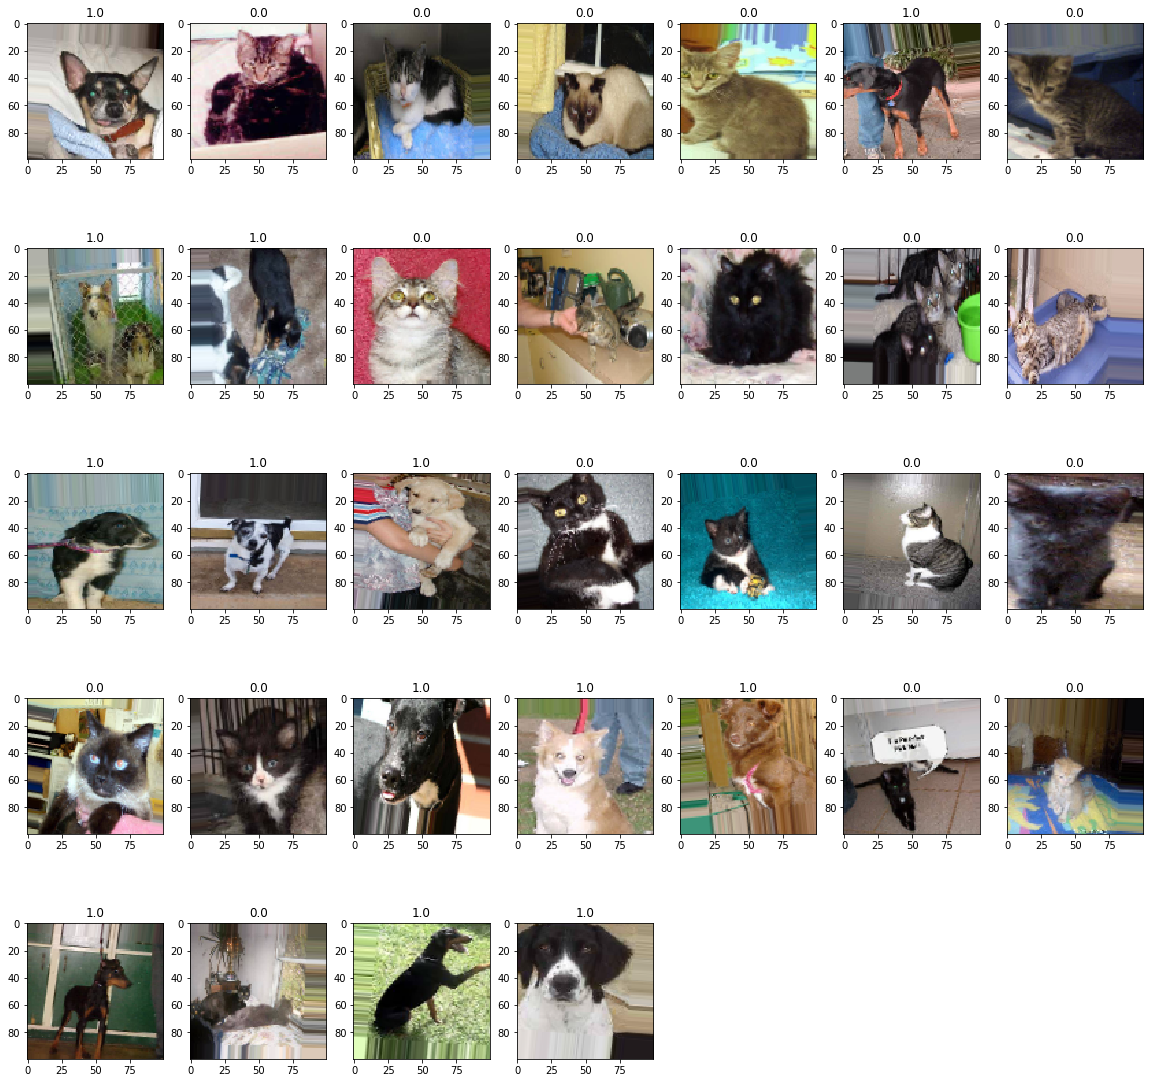

In [12]:
# Sample 이미지 확인하기
images, labels = train_generator[0]

fig = plt.figure(figsize=(20,20))

for idx, (image, label) in enumerate(zip(images, labels),1):
    ax = fig.add_subplot(5,7,idx)
    ax.set_title(label)
    image = (image - image.min())/(image.max()-image.min())
    ax.imshow(image)
plt.show()

### (2) 모델 학습 형태 지정하기

Fine-Tuning할 때에는 보다 작은 learning Rate을 이용해야 합니다.<br>
여기서는 5e-6를 이용하도록 하겠습니다.

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropyt

ImportError: cannot import name 'BinaryCrossentropyt'

In [ ]:
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(lr=5e-6),
              metrics=['acc'])

### (3) 모델 학습시키기

In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=test_generator,
                    validation_steps=50)

<br>

## 4. Class Activation Map 구하기

* Class Activation Map을 구하기 위해서는, 우리는 마지막 Dense Layer의 가중치 정보와<br> 마지막 Feature_map의 정보를 곱해주어야 합니다.
* 이러한 과정은 Tensorflow로 구현하도록 하겠습니다.

### (1) 마지막 Layer의 가중치 정보 가져오기

In [ ]:
weight, bias = model.layers[-1].get_weights()

In [ ]:
weight.shape

### (2) Class Activation Map 구성하기

In [ ]:
output = model.layers[-3].output

cam = output * tf.transpose(weight)
cam = tf.reduce_mean(cam, axis=-1)

model = Model(model.inputs, cam)

### (3) 결과 시각화하기

In [ ]:
def blend_heatmap(image, heatmap, ratio=0.5):
    h, w = image.shape[:2]
    heatmap = cv2.resize(heatmap,(w,h))
    
    # Heat Map과 image 모두 정규화하기
    heatmap = ((heatmap - heatmap.min())/
               (heatmap.max() - heatmap.min()))
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = heatmap / 255.
    
    norm_image = ((image - image.min())/
                  (image.max() - image.min()))
    blend_image = (heatmap * ratio 
                   + norm_image * (1-ratio))
    return blend_image

In [ ]:
images, labels = test_generator[0]

heatmaps = model.predict(images)

for idx, (heatmap, image, label) in enumerate(zip(heatmaps, images, labels)):
    result = blend_heatmap(image, heatmap,0.3)
    if label == 1.:
        print("label : dog")
    else:
        print("label : cat")
    
    plt.imshow(result)
    plt.show()
    
    if idx > 10:
        break

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/14

---